In [2]:
from math import sqrt
import random
import itertools as it
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import kwant


class Honeycomb(kwant.lattice.Polyatomic):
    """Honeycomb lattice with methods for dealing with hexagons"""

    def __init__(self, name=''):
        prim_vecs = [[sqrt(3) / 2, 0.5], [0, 1]]  # bravais lattice vectors
        # offset the lattice so that it is symmetric around x and y axes
        basis_vecs = [[-1 / sqrt(12), -0.5], [1 / sqrt(12), -0.5]]
        super(Honeycomb, self).__init__(prim_vecs, basis_vecs, name)
        self.a, self.b = self.sublattices

    def hexagon(self, tag):
        """ Get sites belonging to hexagon with the given tag.
            Returns sites in counter-clockwise order starting
            from the lower-left site.
        """
        tag = ta.array(tag)
        #         a-sites b-sites
        deltas = [(0, 0), (0, 0),
                  (1, 0), (0, 1),
                  (0, 1), (-1, 1)]
        lats = it.cycle(self.sublattices)
        return (lat(*(tag + delta)) for lat, delta in zip(lats, deltas))

    def hexagon_neighbors(self, tag, n=1):
        """ Get n'th nearest neighbor hoppings within the hexagon with
            the given tag.
        """
        hex_sites = list(self.hexagon(tag))
        return ((hex_sites[(i + n) % 6], hex_sites[i % 6]) for i in xrange(6))


def ribbon(W, L):
    def shape(pos):
        return (-L <= pos[0] <= L and -W <= pos[1] <= W)

    return shape


def ribbon_L(W, L):
    def shape(pos):
        return (-L <= pos[0] <= 0 and -W <= pos[1] <= W)

    return shape

def ribbon_R(W, L):
    def shape(pos):
        return (0 <= pos[0] <= L and -W <= pos[1] <= W)

    return shape


def onsite_potential(site, params):
    return params['ep']


def kinetic(site_i, site_j, params):
    return -params['gamma']


lat = Honeycomb()
pv1, pv2 = lat.prim_vecs
xsym = kwant.TranslationalSymmetry(pv2 - 2 * pv1)  # lattice symmetry in -x direction
ysym = kwant.TranslationalSymmetry(-pv2)  # lattice symmetry in -y direction


def create_lead_h(W, symmetry, axis=(0, 0)):
    lead = kwant.Builder(symmetry)
    lead[lat.wire(axis, W)] = 0.
    lead[lat.neighbors(1)] = kinetic
    return lead


def create_system(W, L):
    ## scattering region ##
    sys = kwant.Builder()
    sys[lat.shape(ribbon(W, L), (0, 0))] = onsite_potential
    sys[lat.neighbors(1)] = kinetic

    ## leads ##
    leads = [create_lead_h(W, xsym)]
    leads += [lead.reversed() for lead in leads]  # right lead
    for lead in leads:
        sys.attach_lead(lead)
    return sys

def create_nanojunction(WL, WR, L):
    sys = kwant.Builder()
    sys[lat.shape(ribbon_L(WL, L), (0, 0))] = onsite_potential
    sys[lat.shape(ribbon_R(WR, L), (0, 0))] = onsite_potential
    sys[lat.neighbors(1)] = kinetic

    ## leads ##
    leads = [create_lead_h(WL, xsym)]

    leads += [lead.reversed() for lead in [create_lead_h(WR, xsym)]]  # right lead
    for lead in leads:
        sys.attach_lead(lead)
    return sys

def junction(WL, WR, L):
    def shape(pos):
        if pos[0] <= 0:
            (-L <= pos[0] and -WL <= pos[1] <= WL)
        else:
            (pos[0] <= L and -WR <= pos[1] <= WR)

    return shape



def plot_bands(sys):
    fsys = sys.finalized()
    kwant.plotter.bands(fsys.leads[0], args=(dict(gamma=1., ep=0.),))


def plot_conductance(sys, energies):
    fsys = sys.finalized()
    data = []

    for energy in energies:
        smatrix = kwant.smatrix(fsys, energy, args=(dict(gamma=1., ep=0.),))
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy (t)")
    plt.ylabel("conductance (e^2/h)")
    plt.show()


/root/miniconda3/envs/torch/lib/python3.9/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


/tmp/ipykernel_755717/3703012466.py:5: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  fig = kwant.plot(sys, site_color=sns.color_palette("Blues")[4], hop_color=sns.color_palette("Blues")[2],


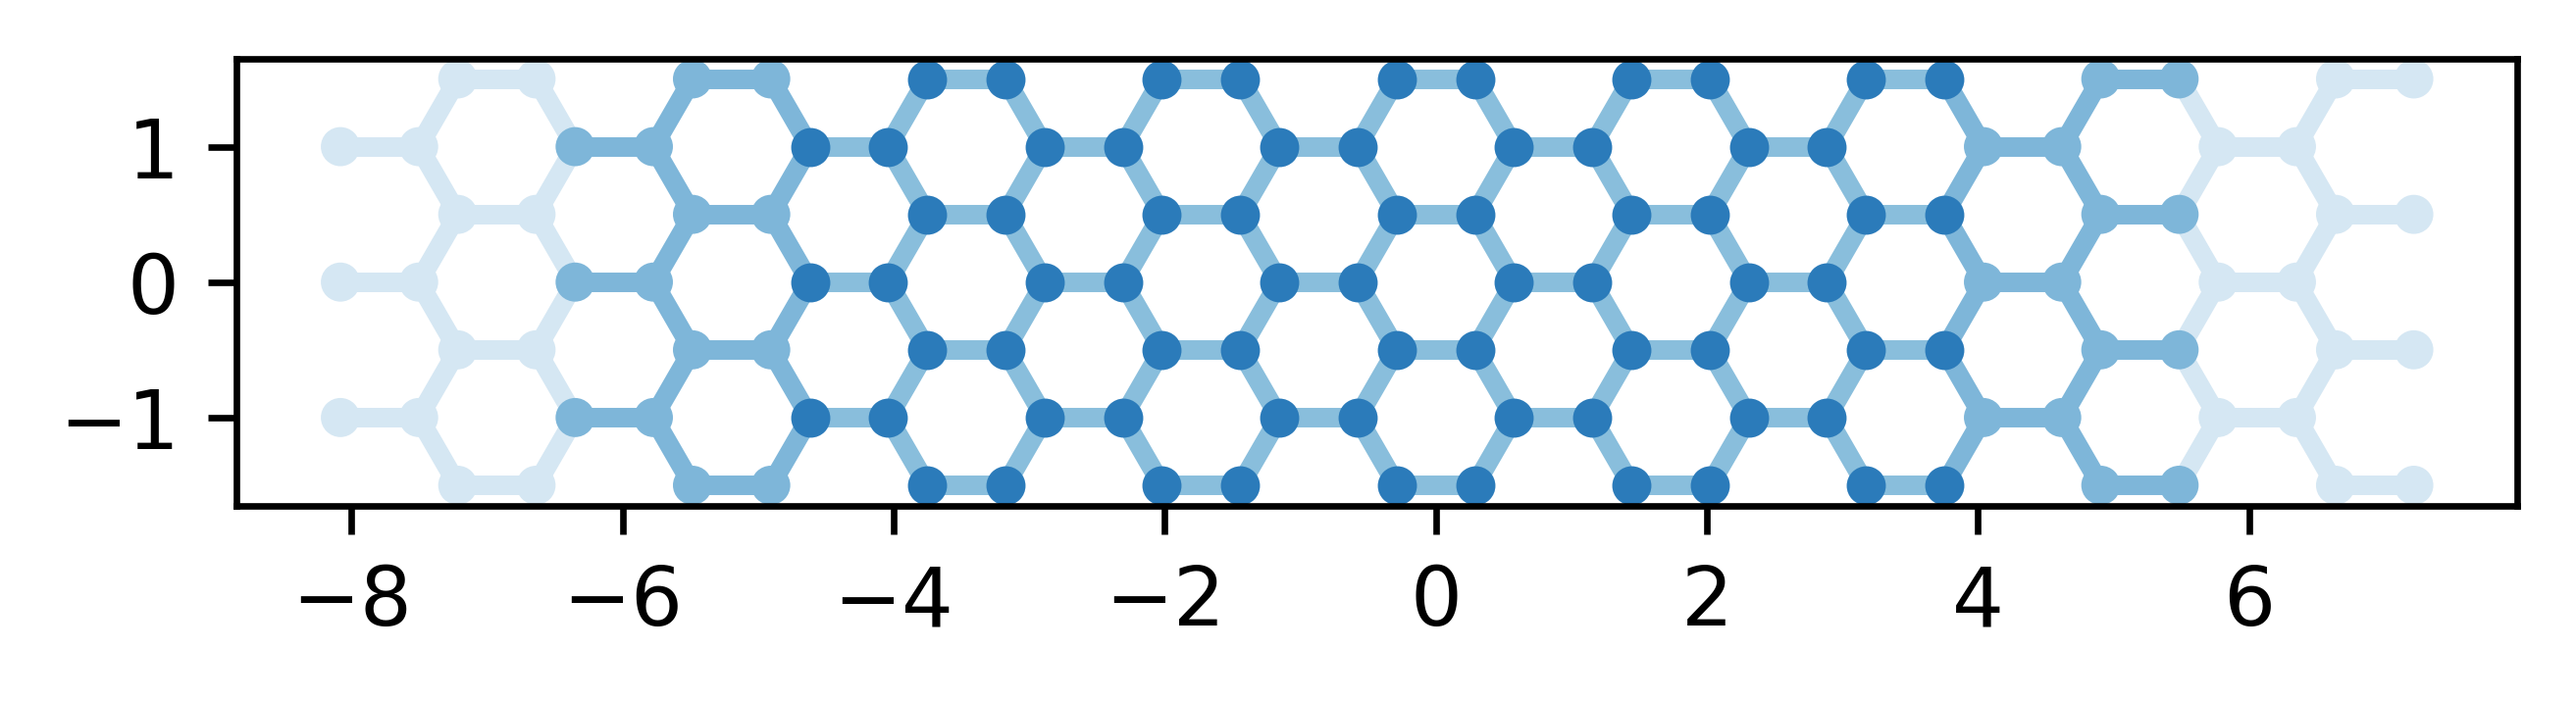

/tmp/ipykernel_755717/2578421789.py:122: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  kwant.plotter.bands(fsys.leads[0], args=(dict(gamma=1., ep=0.),))
/root/miniconda3/envs/torch/lib/python3.9/site-packages/kwant/plotter.py:1409: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  ham = syst.cell_hamiltonian(args, params=params)
/root/miniconda3/envs/torch/lib/python3.9/site-packages/kwant/system.py:273: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  return self.hamiltonian_submatrix(args, cell_sites, cell_sites,
/root/miniconda3/envs/torch/lib/python3.9/site-packages/kwant/plotter.py:1412: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 --

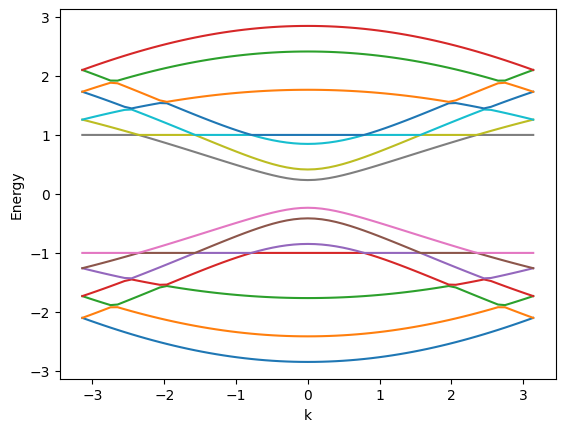

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sys = create_system(1.5, 3.5)
fig = kwant.plot(sys, site_color=sns.color_palette("Blues")[4], hop_color=sns.color_palette("Blues")[2],
            site_edgecolor=sns.color_palette("Blues")[0], hop_lw=2.5e-1, lead_color=sns.color_palette("Blues")[3],
            lead_site_edgecolor=sns.color_palette("Blues")[2], dpi=600, fig_size=(5,2), show=False)
# plt.title("AGNR of width 7", fontsize=12)
# plt.tight_layout()
plt.show()
plot_bands(sys)